In [1]:
#!/usr/bin/env python
# -*- coding: UTF-8

# <p style="text-align: center;"> Charter school identities project:<br/> Analyzing Word Embedding Models with word2vec
<p style="text-align: center;">Creator: Jaren Haber, PhD Candidate<br/>Institution: Department of Sociology, University of California, Berkeley<br/>Date created: July 20, 2018

## Initialize Python

In [1]:
# IMPORTING KEY PACKAGES
import gensim # for word embedding models
import _pickle as cPickle # Optimized version of pickle
import gc # For managing garbage collector

In [4]:
# FOR CLEANING, TOKENIZING, AND STEMMING THE TEXT
from nltk import word_tokenize, sent_tokenize # widely used text tokenizer
from nltk.stem.porter import PorterStemmer # approximate but effective (and common) method of normalizing words: stems words by implementing a hierarchy of linguistic rules that transform or cut off word endings

In [7]:
# FOR VISUALIZATIONS
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns # To make matplotlib prettier
sns.set(style='white')
sns.despine()

# Visualization parameters
% pylab inline 
% matplotlib inline
matplotlib.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


In [6]:
# Define data and model file paths
charters_path = "../../nowdata/traincf_2015_15_250_counts.pkl" # All text data; only charter schools (regardless if open or not)
wordsent_path = "../data/wem_wordsent_data_train250_nostem.pkl"
phrasesent_path = "../data/wem_phrasesent_data_train250_nostem.pkl"
wem_path = "../data/wem_model_train250_nostem.txt"
wem_newpath = "../data/wem_model_train250_nostem_unlapped_300d.txt"

# Define file paths to existing dicts
ess_path = "../dicts/ess_dict.txt"
prog_path = "../dicts/prog_dict.txt"
rit_path = "../dicts/rit_dict.txt"

# Define file paths for new dicts
ess_valid_path = "../dicts/ess_valid.txt"
prog_valid_path = "../dicts/prog_valid.txt"
rit_valid_path = "../dicts/rit_valid.txt"
ess_polar = "../dicts/ess_polar.txt"
prog_polar = "../dicts/prog_polar.txt"
rit_polar = "../dicts/rit_polar.txt"

## Define helper functions

In [8]:
def quickpickle_load(picklepath):
    '''Very time-efficient way to load pickle-formatted objects into Python.
    Uses C-based pickle (cPickle) and gc workarounds to facilitate speed. 
    Input: Filepath to pickled (*.pkl) object.
    Output: Python object (probably a list of sentences or something similar).'''

    with open(picklepath, 'rb') as loadfile:
        
        gc.disable() # disable garbage collector
        outputvar = cPickle.load(loadfile) # Load from picklepath into outputvar
        gc.enable() # enable garbage collector again
    
    return outputvar

In [9]:
def write_list(file_path, textlist):
    """Writes textlist to file_path. Useful for recording output of parse_school()."""
    
    with open(file_path, 'w') as file_handler:
        
        for elem in textlist:
            file_handler.write("{}\n".format(elem))
    
    return    

In [10]:
def load_list(file_path):
    """Loads list into memory. Must be assigned to object."""
    
    textlist = []
    with open(file_path) as file_handler:
        line = file_handler.readline()
        while line:
            textlist.append(line)
            line = file_handler.readline()
    return textlist

In [11]:
def load_dict(custom_dict, file_path):
    """
    Loads in a dictionary from a file.
    Each word is stemmed and lower-cased in preparation for matching with word2vec.
    Adds each entry from the dict at file_path to the defined set custom_dict (the input), 
    which can also be an existing dictionary. This allows the creation of combined dictionaries!
    Multi-word dictionary elements (phrases) are transformed into a single word by
    replacing spaces with underscores, e.g. "college oriented" -> "college_oriented".
    """

    with open(file_path) as file_handler:
        line = file_handler.readline()
        while line:
            line = line.replace("\n", "") # Replace newlines at start, to avoid confusing tokenizers
            linetoks = word_tokenize(line)
            
            if len(linetoks) > 1: # For phrases (>1 word long) in dictionary
                line = [PorterStemmer().stem(word.lower()) for word in linetoks]
                line = "_".join(word for word in line)
                custom_dict.add(line.replace("_","")) # Also add element with no space between words
            else:
                line = PorterStemmer().stem(line.lower()) # For single-word dict elements, just stem it
            
            if "-" in line:
                custom_dict.add(line.replace("-","_")) # If appropriate, also add element that replaces "-" with "_"
                custom_dict.add(line.replace("-","")) # Also add element with no space between words
            
            custom_dict.add(line) # Add line after stemming dictionary entries and eliminating newlines
            line = file_handler.readline() # Look for anything else in that line, add that too
            
    return custom_dict

In [12]:
ess_dict, prog_dict, rit_dict, ess_valid, prog_valid, rit_valid = set(), set(), set(), set(), set(), set()

ess_dict = load_dict(ess_dict, ess_path)
prog_dict = load_dict(prog_dict, prog_path)
rit_dict = load_dict(rit_dict, rit_path)

ess_valid = load_dict(ess_valid, ess_valid_path)
prog_valid = load_dict(prog_valid, prog_valid_path)
rit_valid = load_dict(rit_valid, rit_valid_path)

In [13]:
def make_dicts(paths_list):
    '''Create ideology dictionaries: essentialism, progressivism, and ritualism.
    Input: List of paths to all files holding dictionaries.
    Output: List of dictionaries, each of which is a list of terms.'''
    
    keydicts = [] # Initialize list holding all dicts
    
    for path in paths_list:
        thisdict = set() # Initialize variable holding terms
        thisdict = load_dict(thisdict, path) # Load from file into variable
        keydicts.append(thisdict) # Add dict to list of dicts
    
    #ess_dict, prog_dict, rit_dict, all_ideol, all_dicts = set(), set(), set(), set(), set()

    #all_ideol = load_dict(all_ideol, ess_path)
    #all_ideol = load_dict(all_ideol, prog_path) # For complete ideological list, append second ideological dict
    #all_dicts = load_dict(all_ideol, rit_path) # For complete dict list, append ritual dict terms too

    #ess_dict = load_dict(ess_dict, ess_path)
    #prog_dict = load_dict(prog_dict, prog_path)
    #rit_dict = load_dict(rit_dict, rit_path)
    
    #keydicts = [ess_dict, prog_dict, rit_dict]
    
    print("Lists of key terms (dictionaries) loaded!")
    
    return(keydicts)

In [14]:
def dict_cohere(thisdict, wem_model):
    '''Computes the average cosine similarity score of terms within one dictionary with all other terms in that same dictionary,
    effectively measuring the coherence of the dictionary.
    ...question for development: does it make sense to compare the average cosine similarity score between all terms 
    in thisdict and the average cosine similarity among the total model vocabulary? (Could that be, by definition, 0?)
    
    NOTE: For an unknown reason, calling this function deletes terms from thisdict.
    
    Inputs: List of key terms, word2vec model.
    Output: Average cosine similarity score of each word with all other words in the list of key terms.'''
    
    # Initialize average distance variables:
    word_avg_dist = 0
    word_avg_dists = 0
    dict_avg_sim = 0
    all_avg_dists = 0
    model_avg_dists = 0
    
    # Compute average cosine similarity score of each word with other dict words:
    for word in thisdict:
        word_avg_dist = (wem_model.distances(word, other_words=thisdict).sum())/len(thisdict) # Total diffs of word with all other words, take average
        word_avg_dists += word_avg_dist # Add up each average distance, incrementally
    dict_avg_sim = 1 - word_avg_dists/len(thisdict) # Find average cosine similarity score by subtracting avg. distance from 1

    # For comparison, compute average cosine similarity score of each word with ALL other words in the model vocabulary:
    #for word in thisdict:
    #    all_avg_dist = (wem_model.distances(word).sum())/len(model.vocab) # Default is to compare each word with all words
    #    all_avg_dists += all_avg_dist
    #model_avg_dist = 1 - all_avg_dists/len(model.vocab) # Find average cosine similarity score by subtracting avg. distance from 1

    #print("Average cosine similarities by word for this dictionary:       \t" + str(dict_avg_dist))
    #print("Compare to avg. cosine similarities by dict words to ALL words:\t" + str(model_avg_dist))
    
    return dict_avg_sim

In [15]:
def dict_oppose(dict1, dict2, wem_model):
    '''Computes the average cosine similarity score of terms in dict1 with all terms in dict2,
    effectively measuring the opposition/non-coherence between the two dictionaries.
    
    NOTE: For an unknown reason, calling this function deletes terms from thisdict.
    
    Inputs: List of key terms, word2vec model.
    Output: Average cosine similarity score of each word in dict1 with all words in dict2.'''
    
    # Initialize average distance variables:
    word_avg_dist = 0
    word_avg_dists = 0
    dicts_avg_dist = 0
    
    # Compute average cosine similarity score of each term in dict1 with all terms in dict2:
    for word in dict1:
        word_avg_dist = (wem_model.distances(word, other_words=dict2).sum())/len(dict2) # Total diffs of word with all other words, take average
        word_avg_dists += word_avg_dist # Add up each average distance, incrementally
    dicts_avg_dist = word_avg_dists/len(dict1) # Find average cosine similarity score by subtracting avg. distance from 1
    
    return dicts_avg_dist

In [16]:
def focus_dict(thisdict, coredict, maxlen, wem_model):
    '''Focus thisdict by removing least similar word vectors until reaching maxlen.
    If any words from coredict get removed, compensate for fact that they will get added back in.
    
    Input: A list of terms, core terms not to remove, desired length, and word2vec model.
    Output: The input list focused down to desired length, and still containing all the core terms.'''

    core_count = 0 # Counts number of coredict terms that were removed
    extend_count = 0 # Counts number of terms removed to offset the coming boost of core terms (that were removed and will be added back in)

    while len(thisdict) > maxlen: # Narrow thisdict down to maxlen
        badvar = model.doesnt_match(thisdict) # Find least matching term
        thisdict.remove(badvar) # Remove that least focal term, to focus dict
        if badvar in coredict: # Keep track of number of core terms removed
            core_count += 1

    while extend_count < core_count: # Remove terms until length = maxlen - number of core terms removed (to offset those core terms that will be added back in later in this script)
        badvar = model.doesnt_match(thisdict) # Find least matching term
        thisdict.remove(badvar) # Remove that least focal term, to focus dict
        extend_count += 1 # Keep track of # non-core terms added
        if badvar in coredict: # Keep track of number of core terms removed
            core_count += 1
            
    for term in coredict: # Add back in any missing core terms
        if term not in thisdict:
            thisdict.append(term)
            
    thisdict = list(set(thisdict)) # Remove any duplicates
    
    if len(thisdict) != maxlen: # Quality check
        print("WARNING: Function produced a dictionary of length " + str(len(thisdict)) + \
              ", which is not the specified maximum dict length of " + str(maxlen))
    
    return thisdict 

In [17]:
def clean_textlist(textlist):
    """Removes extraneous spaces: at beginning and end of word2vec-format list of strings, 
    and between two parts of word at start of each line.
    
    Input: list of strings in word2vec format, e.g. ["aardvark .40 .01 .21...\n", "banana .25 .71 .06...\n", ...].
    Output: cleaned list of strings in word2vec format, which ideally should work for word2vec model generation."""
    
    unspaced_text = [textlist[0].replace("\n", "")]

    for oneline in textlist[1:]:
        first, pieces, line = "", [], []
        
        if "\\" in oneline:
            continue # Skip lines with URLs, etc.
        
        for piece in oneline.strip(" ").split(" "): # Remove spaces from beginning and end, then split by spaces
            if piece in ["", " ", "1.", "2.", "3.", "4.", "5.", "6.", "7.", "8.", "9.", "10."]:  # ["", " "] or (piece.replace(".", "").isdigit() and literal_eval(piece) >= 1):
                continue # Omit empty or erroneous elements (1.0 or greater)
            elif not piece.replace("-", "").strip("\n").replace(".", "").replace("e", "").isdigit(): # Check if digit (after removing negative signs, decimal points, scientific notation, and newlines)
                first += piece # If not a digit, it's part of the word, so concatenate it with rest of word
            else:
                pieces.append(piece.replace("\n", "")) # If a digit, add it to list of digits in vector

        line = (first + " " + " ".join([piece for piece in pieces])).strip(" ") # Reconstruct vector
        unspaced_text.append(line) # Add to new word2vec text list/ object
    
    return unspaced_text

## Refine & Validate the Dictionaries

In [18]:
model = gensim.models.KeyedVectors.load_word2vec_format(wem_newpath) # Load word2vec model

In [19]:
# dictionary of words in model (may not work for old gensim)
print(len(model.vocab))
sorted(list(model.vocab)[:200])

421373


['a',
 'about',
 'academic',
 'academy',
 'accountability',
 'activities',
 'after',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'apply',
 'april',
 'arcadia',
 'are',
 'as',
 'at',
 'back',
 'be',
 'been',
 'best',
 'board',
 'but',
 'by',
 'calendar',
 'campus',
 'can',
 'change',
 'charter',
 'child',
 'children',
 'choice',
 'class',
 'class_size',
 'classroom',
 'click',
 'college',
 'community',
 'contact',
 'contact_us',
 'courses',
 'curriculum',
 'data',
 'day',
 'district',
 'do',
 'dyslexia',
 'each',
 'education',
 'educational',
 'elementary',
 'email',
 'english',
 'enrollment',
 'events',
 'every',
 'facebook',
 'families',
 'family',
 'february',
 'first',
 'focus',
 'for',
 'form',
 'from',
 'funding',
 'goals',
 'grade',
 'growth',
 'has',
 'have',
 'he',
 'help',
 'her',
 'here',
 'high',
 'his',
 'home',
 'homeschool',
 'how',
 'i',
 'idea',
 'if',
 'in',
 'information',
 'instruction',
 'is',
 'it',
 'its',
 'january',
 'june',
 'kids',
 'leadership',
 'learn',

### Fine-tuning existing INQUIRY dicts

In [23]:
# Define 30 core terms:
inq30 = ['discovery-based', 'student-driven_exploration', 'exploration_and_experimentation', 'laboratory-based', 
         'problem-based', 'prbl', 'learn-by-doing', 
         'project-based', 'project-centered', 
         'experiential', 'experiential_approach', 'experientially',
         'inquiry-based', 'inquiry-driven', 'student-centered_inquiry-based', 'active_inquiry', 
         'constructivist', 'constructivism', 
         'hands-on', 'hand-on', 'hands-on_learning', 'hands-on_and_minds-on', 'hands-on_minds-on', 'hands-on/minds-on', 
         'socratic', 'socratic_method', 'socratic_dialogue',
         'child-centered', 'learner-centered', 'student-centered']

In [24]:
# Load completed dict of 500 terms:
inquiry_fin = [elem.strip('\n') for elem in load_list('../dicts/inquiry.txt')]

sorted(inquiry_fin)

['abilities',
 'abilities_will_be_maximized',
 'ability-grouped',
 'acquire_requisite',
 'active_inquiry',
 'activities',
 'activities/lessons',
 'activity/project',
 'adept_at_facilitating',
 'adherents',
 'adjusted_and_thrived',
 'admittedly_fallible',
 'agile',
 'aligned_to_the_ngss',
 'allegiances',
 'altered/added',
 'amazed_by_the_generosity',
 'anecdotes',
 'appealing_and_relevant',
 'approaches_such_as_sheltered',
 'appropriately_allocated',
 'architecture',
 'arguments_and_informative/explanatory',
 'arithmetic_reasoning',
 'art-filled',
 'artistic',
 'assemble_the_pieces',
 'atomic_nucleus',
 'awaken_the_imagination',
 'bearing_on_the_viability',
 'benefits_of_co-op',
 'bi-literacy',
 'brain-compatible',
 'brain-friendly',
 'break/gross_motor',
 'brighter_tomorrow',
 'brilliantly_infused',
 'brochure_to_solidify',
 'c++_programming',
 'capitalism_and_socialism',
 'career-focused_and_technical',
 'carefully_weigh',
 'case-based',
 'championing_issues',
 'channels_their_energie

In [27]:
# Remove any terms from core dict NOT in current model (these will have to be replaced):
for word in inq30:
    if word not in list(model.vocab):
        inq30.remove(word)
        print("NOT FOUND, REMOVING:\t" + word)
    else:
        #print("FOUND, KEEPING:\t\t" + word)
        pass
    
print("\nDONE")

NOT FOUND, REMOVING:	active_inquiry
NOT FOUND, REMOVING:	socratic_method

DONE


In [32]:
# Remove any terms from dict NOT in current model (these will have to be replaced):
for word in inquiry_fin:
    if word not in list(model.vocab):
        inquiry_fin.remove(word)
        print("NOT FOUND, REMOVING:\t" + word)
    else:
        #print("FOUND, KEEPING:\t\t" + word)
        pass
    
print("\nDONE")


DONE


In [33]:
inquiry_fin = list(set(inquiry_fin)) # Remove duplicates

print("Length of original dict: ", len(inq30))
print("Coherence of original dict: ", str(dict_cohere(inq30, model)))

print("Length of extended dict: ", len(inquiry_fin))
print("Coherence of extended dict: ", str(dict_cohere(inquiry_fin, model)))

Length of original dict:  28
Coherence of original dict:  0.616952845028
Length of extended dict:  363
Coherence of extended dict:  0.459954449831


In [25]:
# Find and display terms (not cosine sim scores) similar to thisdict:
addmore = []
addmore = [tup[0] for tup in model.most_similar(inquiry_fin, topn=200)]
addmore

['2000b',
 'ashreale_mcdowell',
 'lura_said',
 'norman_conquest',
 'suzette_davis',
 'studentsshould',
 'certified_criss',
 'cogent_manner',
 'time-management_and_networking',
 'theses_themes',
 'ap_stylebook',
 'enhanced_with_adherence',
 'ronment',
 'end_we_have…',
 'jibril_has_a_natural',
 'incorpo',
 'unschooling_is_a_less',
 'multi-disciplinary_integrated',
 'name/_logo',
 'indispensable_component',
 'beegle',
 'sub-\xad‐proficient',
 'pedagogically_meaningful',
 'implementa',
 'ms._waninger',
 'parchitecture_project',
 'owe_it_all_to_papa',
 'm.b',
 'mastery-based_and_performancebased',
 'anaconda',
 'jala_hopes',
 'guidance_and_￼11',
 '5:30pm_8:00pm',
 'posted_at_21:25h',
 "katie_o'donnell",
 'past…',
 'artististic',
 'hugh_o_rourke',
 'embrace_their_multilingual',
 'mrs._ciriaco',
 'responsibili',
 'greater_chall',
 'student-leaders',
 'understands_and_utilizes',
 'understan',
 'ttt_says',
 'kcd',
 'highscope',
 'engagestudents',
 'photography_juried',
 'awarded_12.9mm',
 'self

In [27]:
# Find the dict term that fits the others the least (maybe to delete it, to maximize dict coherence):
badterm = model.doesnt_match(inquiry_fin)
badterm

'shared'

In [109]:
#inq_write.remove(badterm)

print(len(inquiry_fin))
print(dict_cohere(inquiry_fin, model))

470
0.516267091916


In [29]:
inq470 = inquiry_fin

for term in inq30:
    if term in inq470:
        inq470.remove(term)
        
inq_write = sorted(inq30) + sorted(inq470)

inq_write

['active_inquiry',
 'child-centered',
 'constructivism',
 'constructivist',
 'discovery-based',
 'experiential',
 'experiential_approach',
 'experientially',
 'exploration_and_experimentation',
 'hand-on',
 'hands-on',
 'hands-on/minds-on',
 'hands-on_and_minds-on',
 'hands-on_learning',
 'hands-on_minds-on',
 'inquiry-based',
 'inquiry-driven',
 'laboratory-based',
 'learn-by-doing',
 'learner-centered',
 'prbl',
 'problem-based',
 'project-based',
 'project-centered',
 'socratic',
 'socratic_dialogue',
 'socratic_method',
 'student-centered',
 'student-centered_inquiry-based',
 'student-driven_exploration',
 'abilities',
 'abilities_will_be_maximized',
 'ability-grouped',
 'acquire_requisite',
 'activities',
 'activities/lessons',
 'activity/project',
 'adept_at_facilitating',
 'adherents',
 'adjusted_and_thrived',
 'admittedly_fallible',
 'agile',
 'aligned_to_the_ngss',
 'allegiances',
 'altered/added',
 'amazed_by_the_generosity',
 'anecdotes',
 'appealing_and_relevant',
 'approac

In [578]:
#write_list("../dicts/inquiry.txt", inq_write)

### Looking for STEM cluster

In [93]:
stem = ['stem', 
        'technology_engineering', 
                   'art+design', 
                   'steam', 
                   'cstem', 
                   'stemr', 
                   's.t.e.a.m.s', 
                   'steams_expo', 
                   'creators_and_innovators', 
                   'mathematical_experiments', 
                   'multiliteracy', 
                   'biology/environmental', 
                   'kits/manipulators', 
                   'steam_is_an_acronym', 
                   'ap_enviromental', 
                   'biology_earth/space']

print(dict_cohere(stem, model))
print(dict_oppose(stem, inq30, model))
print(dict_oppose(stem, disc30, model))
model.most_similar(stem, topn=50)

0.655073378235
0.563798348109
0.752837451299


[('department_courses………………………………………………15', 0.8892005085945129),
 ('widlife_and_fisheries', 0.8801015019416809),
 ('ducky', 0.8736292123794556),
 ('a4/b4', 0.8726124167442322),
 ('enrichment_in_s.t.e.a.m.science', 0.8703518509864807),
 ('comprise_the_fastest', 0.8699126243591309),
 ('heedum', 0.8692235946655273),
 ('fiction_fantasy**', 0.8688291311264038),
 ('7ydfsdf', 0.8685446977615356),
 ('a5/b5', 0.8672053813934326),
 ('actually_it_is_rocket', 0.8661134839057922),
 ('greg_moen', 0.8657588958740234),
 ('sc.4.e.6.4', 0.8650283813476562),
 ('-inspired', 0.8624314665794373),
 ('enviornmental', 0.8587949275970459),
 ('a2/b2', 0.8563480377197266),
 ('dean_of_students/hs', 0.8551861047744751),
 ('units*', 0.8531049489974976),
 ('matt_nolen', 0.8527501821517944),
 ('gps_tracking', 0.8524307012557983),
 ('prerequisites_preferably', 0.8520702719688416),
 ('kristin_marques', 0.851394534111023),
 ('arn_allemand', 0.8508539199829102),
 ('fusion_and_tci', 0.8492375016212463),
 ('at/or', 0.848543

### Fine-tuning existing DISCIPLINE dict

In [24]:
# Define 30 core terms:
disc30 = ['discipline', 'disciplinary', 
          'no-excuses', 'zero-tolerance', 'zero_tolerance', 'zero-tolerance_policy', 
          'expel', 'expellable', 'expulsion', 'suspension', 'suspended', 
          'misbehavior', 'disobedience', 'absenteeism', 'inappropriate', 
          'perpetrator', 'crime', 'criminal', 'illegal', 'drugs', 'drug-related', 
          'violation', 'violate', 'penalty', 'punish', 'penalize', 
          'authority', 'deterrence', 'deter', 
          'behavioral_expectations']

In [25]:
# Load completed dict of 500 terms:
disc_fin = [elem.strip('\n') for elem in load_list('../dicts/discipline.txt')]
sorted(disc_fin)

['120a.34',
 '121a.582',
 '121a.69',
 'abandoning',
 'absentee_voting',
 'absenteeism',
 'accusation',
 'accusations',
 'activity_has_a_dignifying',
 'ad-hoc_committees',
 'adequate_residence',
 'adjudicated_delinquent',
 'adverse_reaction',
 'aggressor_target',
 'aircraft_crash',
 'alcohol',
 'alimony_as_shown',
 'allegation',
 'allegations',
 'alleged',
 'altered_by_chemical',
 'amendments_thereto',
 'ammunition',
 'anabolic_steroid',
 'annexed',
 'anthrax_spores',
 'anti-retaliation',
 'arbitration',
 'arbitration_proceedings',
 'arrested_convicted',
 'arson',
 'arson_or_criminal',
 'articulable_and_significant',
 'assault',
 'assaulted',
 'assaulting',
 'assisted_or_represented',
 'attached_to_the_duplicate',
 'attempting_to_commit',
 'attempts_to_kiss',
 'authority',
 'authority_to_impose',
 'aversive_techniques',
 'barbiturate_marijuana',
 'barbiturates',
 'bare_skin',
 'behavior/discipline',
 'behavioral_expectations',
 'bestiality',
 'bias_incident',
 'bigoted',
 'block_pores',

In [121]:
# Remove any terms from dict NOT in this model's vocab:
for word in disc_fin:
    if word not in list(model.vocab):
        disc_fin.remove(word)
        print("NOT FOUND, REMOVING:\t" + word)
    else:
        #print("FOUND, KEEPING:\t\t" + word)
        pass

print("\nDONE")


DONE


In [124]:
disc_fin = list(set(disc_fin)) # Remove duplicates

print("Length of original dict: ", len(disc30))
print("Coherence of original dict: ", str(dict_cohere(disc30, model)))

print("Length of extended dict: ", len(disc_fin))
print("Coherence of extended dict: ", str(dict_cohere(disc_fin, model)))

Length of original dict:  30
Coherence of original dict:  0.35843129158
Length of extended dict:  500
Coherence of extended dict:  0.548640980957


In [35]:
# Find the dict term that fits the others the least (maybe to delete it, to maximize dict coherence):
badterm = model.doesnt_match(disc_fin)
badterm

'uniform'

In [36]:
#disc_write.remove(badterm)
print(len(disc_fin))
print(dict_cohere(disc_fin, model))

500
0.548640980042


In [37]:
# Find and display terms (not cosine sim scores) similar to thisdict:
addmore = []
addmore = [tup[0] for tup in model.most_similar(disc_fin, topn=200)]
addmore

['confiscation_of_the_weapon',
 'condi',
 'tobacco-related',
 'crime_of_stalking',
 'abandoning_or_endangering',
 'inflict_damage',
 '2000b',
 'fighting_or_threatening',
 'gunfire_is_identified',
 'furnishing_a_firearm',
 'influence_of_any_narcotic',
 'firearms_weapons',
 'discriminatory_attacks',
 'financially_liable',
 'term_firearm',
 'legally_intoxicated',
 'attempted_theft',
 '§§624.714',
 'loomis-usd.k12.ca.us',
 'possessing_a_weapon',
 'b01',
 '**_caution',
 'wpo',
 'arbitra',
 'fmla/cfra-qualifying_purpose',
 'sbec_rules',
 'reckless_misconduct',
 'causing_damage',
 'beegle',
 'victim_suffers',
 'h.i.b',
 'zoster',
 '266c_288a',
 'norman_conquest',
 'angel_piña',
 'permit-holder_s_vehicle',
 'x213',
 'manufacturer_for_non-prescription',
 'weapon_or_firearm',
 '122a.41_subd',
 'completion_of_an_investigation',
 'hostages_or_cause',
 'shirlandra',
 'iv.a.1.b',
 'clothes_which_are_suggestive',
 'inflammatory_situations',
 'toreturn',
 'gun_a_knife',
 'calling_833-216-safe',
 'exci

In [38]:
disc470 = disc_fin

for term in disc30:
    if term in disc470:
        disc470.remove(term)
        
disc_write = sorted(disc30) + sorted(disc470)

disc_write

['absenteeism',
 'authority',
 'behavioral_expectations',
 'crime',
 'criminal',
 'deter',
 'deterrence',
 'disciplinary',
 'discipline',
 'disobedience',
 'drug-related',
 'drugs',
 'expel',
 'expellable',
 'expulsion',
 'illegal',
 'inappropriate',
 'misbehavior',
 'no-excuses',
 'penalize',
 'penalty',
 'perpetrator',
 'punish',
 'suspended',
 'suspension',
 'violate',
 'violation',
 'zero-tolerance',
 'zero-tolerance_policy',
 'zero_tolerance',
 '120a.34',
 '121a.582',
 '121a.69',
 'abandoning',
 'absentee_voting',
 'accusation',
 'accusations',
 'activity_has_a_dignifying',
 'ad-hoc_committees',
 'adequate_residence',
 'adjudicated_delinquent',
 'adverse_reaction',
 'aggressor_target',
 'aircraft_crash',
 'alcohol',
 'alimony_as_shown',
 'allegation',
 'allegations',
 'alleged',
 'altered_by_chemical',
 'amendments_thereto',
 'ammunition',
 'anabolic_steroid',
 'annexed',
 'anthrax_spores',
 'anti-retaliation',
 'arbitration',
 'arbitration_proceedings',
 'arrested_convicted',
 'a

In [305]:
#write_list("../dicts/discipline.txt", disc_write)

In [ ]:
discnew = ['discipline', 'disciplinary', 
          'no-excuses', 'zero-tolerance', 'zero_tolerance', 'zero-tolerance_policy', 
          'expel', 'expellable', 'expulsion', 'suspension', 'suspended', 
          'misbehavior', 'disobedience', 'absenteeism', 'inappropriate', 
          'perpetrator', 'crime', 'criminal', 'illegal', 'drugs', 'drug-related', 
          'violation', 'violate', 'penalty', 'punish', 'penalize', 
          'authority', 'deterrence', 'deter', 
          'behavioral_expectations']

In [54]:
discnew = ['deter',
           'zero_tolerance',
           'expel',
           'suspended',
           'expulsion',
           'no-excuses',
           'violate',
           'misbehavior',
           'zero-tolerance',
           'deterrence',
           'penalty',
           'perpetrator',
           'penalize',
           'disobedience',
           'violation',
           'punish',
           'zero-tolerance_policy',
           'expellable',
           'drug-related',
           'suspension', 
          'warranting', 
          'transgression', 
          'condones', 
          'false_accusation', 
          'aversive_techniques', 
          'disciplined_appropriately', 
          'reasonably_conclude', 
          'perpetrate', 
          'revocation_of_privileges', 
          'tobacco-related']

print(str(dict_cohere(discnew, model)))
print(len(discnew))
discnew = list(set(discnew))
model.most_similar(discnew, topn=50)

0.526976363924
30


[('found_to_have_retaliated', 0.867648720741272),
 ('possessing_a_weapon', 0.8576602935791016),
 ('consequences_for_the_perpetrator', 0.8556523323059082),
 ('disciplinaryaction', 0.8550125956535339),
 ('financially_liable', 0.8538945317268372),
 ('drug_or_alcohol-related', 0.8506314754486084),
 ('permit-holder_s_vehicle', 0.84807288646698),
 ('***p', 0.8477877378463745),
 ('serious_misbehavior', 0.8457537889480591),
 ('weapons_drugs', 0.8434295654296875),
 ('violations_of_this_rule', 0.8424465656280518),
 ('isolated_incidents', 0.8404828310012817),
 ('expellable_offense', 0.8383771181106567),
 ('harassing_behaviors', 0.8380646109580994),
 ('121a.69', 0.8373596668243408),
 ('obstruct_the_investigation', 0.8372165560722351),
 ('\x04_willful', 0.8366475105285645),
 ('investigation_is_strictly', 0.8365072011947632),
 ('bus/bus_stop', 0.8359252214431763),
 ('tolerate_retaliation', 0.8354482650756836),
 ('retaliation_reprisal', 0.8342695236206055),
 ('tolerates', 0.8341689109802246),
 ('fals

### Compare dicts in vector space

In [66]:
# Define 30 core terms:
inq30 = ['discovery-based', 'student-driven_exploration', 'exploration_and_experimentation', 'laboratory-based', 
         'problem-based', 'prbl', 'learn-by-doing', 
         'project-based', 'project-centered', 
         'experiential', 'experiential_approach', 'experientially',
         'inquiry-based', 'inquiry-driven', 'student-centered_inquiry-based', 'active_inquiry', 
         'constructivist', 'constructivism', 
         'hands-on', 'hand-on', 'hands-on_learning', 'hands-on_and_minds-on', 'hands-on_minds-on', 'hands-on/minds-on', 
         'socratic', 'socratic_method', 'socratic_dialogue',
         'child-centered', 'learner-centered', 'student-centered']

disc30 = ['discipline', 'disciplinary', 
          'no-excuses', 'zero-tolerance', 'zero_tolerance', 'zero-tolerance_policy', 
          'expel', 'expellable', 'expulsion', 'suspension', 'suspended', 
          'misbehavior', 'disobedience', 'absenteeism', 'inappropriate', 
          'perpetrator', 'crime', 'criminal', 'illegal', 'drugs', 'drug-related', 
          'violation', 'violate', 'penalty', 'punish', 'penalize', 
          'authority', 'deterrence', 'deter', 
          'behavioral_expectations']

inquiry_fin = [elem.strip('\n') for elem in load_list('../dicts/inquiry.txt')]
disc_fin = [elem.strip('\n') for elem in load_list('../dicts/discipline.txt')]

In [65]:
# Use random adds to create a few dicts of different lengths from max length of 500:

print("TESTING DIFFERENT LENGTHS USING RANDOM ADDITIONS:\n")

inqlist, disclist = [], []; inqlist = inq30; disclist = disc30 # initialize placeholder for each growing dict
#print("Dict lengths (IBL, FD): " + str(len(inqlist)) + ", " + str(len(disclist)))
print(str(len(inqlist)) + "-term dicts have this much opposition: ", str(dict_oppose(inq30, disc30, model)))
print(str(len(inqlist)) + "-term dicts have this much coherence (IBL, FD): ", str(dict_cohere(inq30, model)) + ", " + str(dict_cohere(disc30, model)))
print()

# 40 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq30, inquiry_fin)], size=10, replace=False))
disclist.extend(np.random.choice([term for term in filter(lambda x: x not in disc30, disc_fin)], size=10, replace=False))
inq40, disc40 = [], []; inq40 = inqlist; disc40 = disclist
#print("Dict lengths (IBL, FD): " + str(len(inqlist)) + ", " + str(len(disclist)))
print(str(len(inqlist)) + "-term dicts have this much opposition: ", str(dict_oppose(inq40, disc40, model)))
print(str(len(inqlist)) + "-term dicts have this much coherence (IBL, FD): ", str(dict_cohere(inq40, model)) + ", " + str(dict_cohere(disc40, model)))
print()

# 50 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq40, inquiry_fin)], size=10, replace=False))
disclist.extend(np.random.choice([term for term in filter(lambda x: x not in disc40, disc_fin)], size=10, replace=False))
inq50 = inqlist; disc50 = disclist
#print("Dict lengths (IBL, FD): " + str(len(inqlist)) + ", " + str(len(disclist)))
print(str(len(inqlist)) + "-term dicts have this much opposition: ", str(dict_oppose(inq50, disc50, model)))
print(str(len(inqlist)) + "-term dicts have this much coherence (IBL, FD): ", str(dict_cohere(inq50, model)) + ", " + str(dict_cohere(disc50, model)))
print()

# 75 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq50, inquiry_fin)], size=25, replace=False))
disclist.extend(np.random.choice([term for term in filter(lambda x: x not in disc50, disc_fin)], size=25, replace=False))
inq75 = inqlist; disc75 = disclist
#print("Dict lengths (IBL, FD): " + str(len(inqlist)) + ", " + str(len(disclist)))
print(str(len(inqlist)) + "-term dicts have this much opposition: ", str(dict_oppose(inq75, disc75, model)))
print(str(len(inqlist)) + "-term dicts have this much coherence (IBL, FD): ", str(dict_cohere(inq75, model)) + ", " + str(dict_cohere(disc75, model)))
print()

# 100 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq75, disc_fin)], size=25, replace=False))
disclist.extend(np.random.choice([term for term in filter(lambda x: x not in disc75, disc_fin)], size=25, replace=False))
inq100 = inqlist; disc100 = disclist
#print("Dict lengths (IBL, FD): " + str(len(inqlist)) + ", " + str(len(disclist)))
print(str(len(inqlist)) + "-term dicts have this much opposition: ", str(dict_oppose(inq100, disc100, model)))
print(str(len(inqlist)) + "-term dicts have this much coherence (IBL, FD): ", str(dict_cohere(inq100, model)) + ", " + str(dict_cohere(disc100, model)))
print()

# 200 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq100, disc_fin)], size=100, replace=False))
disclist.extend(np.random.choice([term for term in filter(lambda x: x not in disc100, disc_fin)], size=100, replace=False))
inq200 = inqlist; disc200 = disclist
#print("Dict lengths (IBL, FD): " + str(len(inqlist)) + ", " + str(len(disclist)))
print(str(len(inqlist)) + "-term dicts have this much opposition: ", str(dict_oppose(inq200, disc200, model)))
print(str(len(inqlist)) + "-term dicts have this much coherence (IBL, FD): ", str(dict_cohere(inq200, model)) + ", " + str(dict_cohere(disc200, model)))
print()

# 300 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq200, disc_fin)], size=100, replace=False))
disclist.extend(np.random.choice([term for term in filter(lambda x: x not in disc200, disc_fin)], size=100, replace=False))
inq300 = inqlist; disc300 = disclist
#print("Dict lengths (IBL, FD): " + str(len(inqlist)) + ", " + str(len(disclist)))
print(str(len(inqlist)) + "-term dicts have this much opposition: ", str(dict_oppose(inq300, disc300, model)))
print(str(len(inqlist)) + "-term dicts have this much coherence (IBL, FD): ", str(dict_cohere(inq300, model)) + ", " + str(dict_cohere(disc300, model)))
print()

# 400 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq300, disc_fin)], size=100, replace=False))
disclist.extend(np.random.choice([term for term in filter(lambda x: x not in disc300, disc_fin)], size=100, replace=False))
inq400 = inqlist; disc400 = disclist
#print("Dict lengths (IBL, FD): " + str(len(inqlist)) + ", " + str(len(disclist)))
print(str(len(inqlist)) + "-term dicts have this much opposition: ", str(dict_oppose(inq400, disc400, model)))
print(str(len(inqlist)) + "-term dicts have this much coherence (IBL, FD): ", str(dict_cohere(inq400, model)) + ", " + str(dict_cohere(disc400, model)))
print()

print("500-term dicts have this much opposition: ", str(dict_oppose(inquiry_fin, disc_fin, model)))
print("500-term dicts have this much coherence (IBL, FD): ", str(dict_cohere(inquiry_fin, model)) + ", " + str(dict_cohere(disc_fin, model)))

TESTING DIFFERENT LENGTHS USING RANDOM ADDITIONS:

30-term dicts have this much opposition:  0.749881225162
30-term dicts have this much coherence (IBL, FD):  0.54740960651, 0.35843129158

40-term dicts have this much opposition:  0.708685903549
40-term dicts have this much coherence (IBL, FD):  0.517980412245, 0.389402656555

50-term dicts have this much opposition:  0.676498849487
50-term dicts have this much coherence (IBL, FD):  0.506710433197, 0.414577153015

75-term dicts have this much opposition:  0.636627347819
75-term dicts have this much coherence (IBL, FD):  0.49572160475, 0.446630611504

100-term dicts have this much opposition:  0.597782938385
100-term dicts have this much coherence (IBL, FD):  0.461071811676, 0.464137736511

200-term dicts have this much opposition:  0.529009175682
200-term dicts have this much coherence (IBL, FD):  0.460896015739, 0.513742266083

300-term dicts have this much opposition:  0.503255800883
300-term dicts have this much coherence (IBL, FD):

In [68]:
# Use removal of least similar word vectors to create a few dicts of different lengths from max length of 500:
#inqlist = inq30; disclist = disc30 # initialize placeholder for each growing dict

lens_list = [500, 400, 300, 200, 100, 75, 60, 50, 40, 30] # Define desired dict lengths

# Load full 500-term dicts:
inquiry_fin = [elem.strip('\n') for elem in load_list('../dicts/inquiry.txt')]
disc_fin = [elem.strip('\n') for elem in load_list('../dicts/discipline.txt')]

print('TESTING DICT LENGTHS BY REMOVING LEAST SIMILAR WORD VECTORS:\n')

for dictlen in lens_list: 
    inqdict, discdict = [], []
    
    inqdict = focus_dict(inquiry_fin, inq30, dictlen, model)
    discdict = focus_dict(disc_fin, disc30, dictlen, model)
    
    print(str(dictlen) + "-term dicts have this much opposition: ", str(dict_oppose(inqdict, discdict, model)))
    print(str(dictlen) + "-term dicts have this much coherence (IBL, FD): ", str(dict_cohere(inqdict, model)) + ", " + str(dict_cohere(discdict, model)))
    print()

TESTING DICT LENGTHS BY REMOVING LEAST SIMILAR WORD VECTORS:

500-term dicts have this much opposition:  0.551563987854
500-term dicts have this much coherence (IBL, FD):  0.510294364624, 0.548640980957

400-term dicts have this much opposition:  0.454299941397
400-term dicts have this much coherence (IBL, FD):  0.614996711111, 0.637216437674

300-term dicts have this much opposition:  0.412039024353
300-term dicts have this much coherence (IBL, FD):  0.660451052602, 0.671811217329

200-term dicts have this much opposition:  0.381595571423
200-term dicts have this much coherence (IBL, FD):  0.684243439388, 0.673996708202

100-term dicts have this much opposition:  0.42322995224
100-term dicts have this much coherence (IBL, FD):  0.659672869873, 0.605848115158

75-term dicts have this much opposition:  0.473494670275
75-term dicts have this much coherence (IBL, FD):  0.627048411051, 0.551265799628

60-term dicts have this much opposition:  0.531365802553
60-term dicts have this much coh

## Surprising trends in analyzing how dictionary length affects inter-dictionary opposition and within-dictionary coherence:
### Greater lengths make for more within-dictionary coherence, but less across-dictionary opposition.
### Trimming word vectors randomly yields dictionaries that are less coherent and more opposing than does trimming those word vectors least similar to the others in the dictionary.
#### Caveat: The above patterns assume (perhaps consequentially, perhaps not) that as we trim dictionaries, we are keeping a small, core list of concepts (here, 30) intact within each dictionary. The size of this core may influence the above dynamics, as may the relative size of the total dictionary compared to the core list.

In [36]:
model.most_similar(positive=inquiry_fin, negative=disc_fin, topn=20) # IBL - FD

[('grade/posit', 0.3184661269187927),
 ('nbhvarsitych_yahoo.com', 0.2934500277042389),
 ('http_//www.youtube.com/embed/rstotrxdoqg', 0.27947884798049927),
 ('2013-02-20_parent_teacher_student_coalition_agenda.pdf',
  0.2703778147697449),
 ('wclayasuprep.weebly.com', 0.26753416657447815),
 ('becom_a_kippster', 0.25791293382644653),
 ('1,514,043', 0.25642746686935425),
 ('15,636', 0.25472795963287354),
 ('2018-03-22t14:33:30z', 0.2545211911201477),
 ('hcordova_newamericaschoolnm.org', 0.25319141149520874),
 ('http_//parnassusprep.com/wp-content/uploads/2018/04/parnassus_0193-1-150x150.jpg',
  0.2528453469276428),
 ('02.01.18_ed', 0.2506014406681061),
 ('process1_temp.php', 0.24953339993953705),
 ('http_//www.universityofcalifornia.edu/admissions/', 0.24945060908794403),
 ('sourc_the_star-ledg', 0.24655720591545105),
 ('105,141', 0.24613776803016663),
 ('may07', 0.24503378570079803),
 ('assignment_page_help_card.pdf', 0.24145573377609253),
 ('produkt_25/35', 0.2400006800889969),
 ('627,23

In [36]:
model.most_similar(negative=inquiry_fin, positive=disc_fin, topn=20) # FD - IBL

[('grade/posit', 0.3184661269187927),
 ('nbhvarsitych_yahoo.com', 0.2934500277042389),
 ('http_//www.youtube.com/embed/rstotrxdoqg', 0.27947884798049927),
 ('2013-02-20_parent_teacher_student_coalition_agenda.pdf',
  0.2703778147697449),
 ('wclayasuprep.weebly.com', 0.26753416657447815),
 ('becom_a_kippster', 0.25791293382644653),
 ('1,514,043', 0.25642746686935425),
 ('15,636', 0.25472795963287354),
 ('2018-03-22t14:33:30z', 0.2545211911201477),
 ('hcordova_newamericaschoolnm.org', 0.25319141149520874),
 ('http_//parnassusprep.com/wp-content/uploads/2018/04/parnassus_0193-1-150x150.jpg',
  0.2528453469276428),
 ('02.01.18_ed', 0.2506014406681061),
 ('process1_temp.php', 0.24953339993953705),
 ('http_//www.universityofcalifornia.edu/admissions/', 0.24945060908794403),
 ('sourc_the_star-ledg', 0.24655720591545105),
 ('105,141', 0.24613776803016663),
 ('may07', 0.24503378570079803),
 ('assignment_page_help_card.pdf', 0.24145573377609253),
 ('produkt_25/35', 0.2400006800889969),
 ('627,23

In [133]:
# Let's look at two vectors that demonstrate the binary between these ideologies
print(model.most_similar('inquiry-based')) # words core to IBL
print()
print(model.most_similar('zero-tolerance')) # words core to FD

[('qcss_employs', 0.5596227645874023), ('prbl', 0.5487460494041443), ('experiential_approach', 0.5428934097290039), ('integral_to_our_physics-first', 0.5322498679161072), ('student-driven_exploration', 0.5306644439697266), ('research-based_and_has_been_proven', 0.5303560495376587), ('hands-on_and_minds-on', 0.5180636644363403), ('thematic_project-based', 0.5176000595092773), ('showcase_of_self-driven', 0.5140712261199951), ('iqwst', 0.5059105157852173)]

[('disobeying_bus', 0.6657135486602783), ('penalties_for_violating', 0.6490375995635986), ('workplace_violence', 0.6452620029449463), ('egregious', 0.6411598324775696), ('nrs_inclusive', 0.6406236886978149), ('drug-related', 0.6401966214179993), ('disciplinaryaction', 0.6398093104362488), ('hate-motivated', 0.6363762617111206), ('condones', 0.6359834671020508), ('weapons_drugs', 0.6334969401359558)]


In [342]:
# Define 30 core terms:
inq30 = ['discovery-based', 'student-driven_exploration', 'exploration_and_experimentation', 'laboratory-based', 
         'problem-based', 'prbl', 'learn-by-doing', 
         'project-based', 'project-centered', 
         'experiential', 'experiential_approach', 'experientially',
         'inquiry-based', 'inquiry-driven', 'student-centered_inquiry-based', 'active_inquiry', 
         'constructivist', 'constructivism', 
         'hands-on', 'hand-on', 'hands-on_learning', 'hands-on_and_minds-on', 'hands-on_minds-on', 'hands-on/minds-on', 
         'socratic', 'socratic_method', 'socratic_dialogue',
         'child-centered', 'learner-centered', 'student-centered']

disc30 = ['discipline', 'disciplinary', 
          'no-excuses', 'zero-tolerance', 'zero_tolerance', 'zero-tolerance_policy', 
          'expel', 'expellable', 'expulsion', 'suspension', 'suspended', 
          'misbehavior', 'disobedience', 'absenteeism', 'inappropriate', 
          'perpetrator', 'crime', 'criminal', 'illegal', 'drugs', 'drug-related', 
          'violation', 'violate', 'penalty', 'punish', 'penalize', 
          'authority', 'deterrence', 'deter', 
          'behavioral_expectations']

# Load full 500-term dicts:
inquiry_fin = [elem.strip('\n') for elem in load_list('../dicts/inquiry.txt')]
disc_fin = [elem.strip('\n') for elem in load_list('../dicts/discipline.txt')]

In [170]:
# Let's work with the binary between IBL and FD
# first let's find the 30 words closest to each philosophy using the two 30-term dictionaries defined above
inq_words = model.most_similar("inquiry-based", topn=50)
inq_words = [word for word, similarity in inq_words]
#for word in progressivism:
#    prog_words.append(word)
print(inq_words[:20])

['qcss_employs', 'prbl', 'experiential_approach', 'integral_to_our_physics-first', 'student-driven_exploration', 'research-based_and_has_been_proven', 'hands-on_and_minds-on', 'thematic_project-based', 'showcase_of_self-driven', 'iqwst', 'integrated_thematic', 'problem-based', 'problem-centered', 'inter-disciplinary', 'literature-based', 'captivates', 'gdoe', 'appb', 'cross-curricular_project-based', 'life-based']


In [171]:
disc_words = model.most_similar("zero-tolerance", topn=50) # now let's get the 30 most similar words for our FD dictionary
disc_words = [word for word, similarity in disc_words]
#for word in essentialism:
#    ess_words.append(word)
print(disc_words[:20])

['disobeying_bus', 'penalties_for_violating', 'workplace_violence', 'egregious', 'nrs_inclusive', 'drug-related', 'disciplinaryaction', 'hate-motivated', 'condones', 'weapons_drugs', 'willful_violation', 'pattern_of_unwelcome', 'willful_disobedience', 'incremental_disciplinary', 'aversive_techniques', 'withrespect', 'allegations_if_proven', 'dealt_with_immediately', 'try_to_deter', 'weapons_possession']


In [426]:
# Define 30 core terms:
inq30 = ['discovery-based', 'student-driven_exploration', 'exploration_and_experimentation', 'laboratory-based', 
         'problem-based', 'prbl', 'learn-by-doing', 
         'project-based', 'project-centered', 
         'experiential', 'experiential_approach', 'experientially',
         'inquiry-based', 'inquiry-driven', 'student-centered_inquiry-based', 'active_inquiry', 
         'constructivist', 'constructivism', 
         'hands-on', 'hand-on', 'hands-on_learning', 'hands-on_and_minds-on', 'hands-on_minds-on', 'hands-on/minds-on', 
         'socratic', 'socratic_method', 'socratic_dialogue',
         'child-centered', 'learner-centered', 'student-centered']

disc30 = ['discipline', 'disciplinary', 
          'no-excuses', 'zero-tolerance', 'zero_tolerance', 'zero-tolerance_policy', 
          'expel', 'expellable', 'expulsion', 'suspension', 'suspended', 
          'misbehavior', 'disobedience', 'absenteeism', 'inappropriate', 
          'perpetrator', 'crime', 'criminal', 'illegal', 'drugs', 'drug-related', 
          'violation', 'violate', 'penalty', 'punish', 'penalize', 
          'authority', 'deterrence', 'deter', 
          'behavioral_expectations']

core_words = inq30 + disc30
inquiry_fin = [elem.strip('\n') for elem in load_list('../dicts/inquiry.txt')]
disc_fin = [elem.strip('\n') for elem in load_list('../dicts/discipline.txt')]

# Use random adds to create a few dicts of different lengths from max length of 500:

inqlist, disclist = [], []; inqlist = inq30; disclist = disc30 # initialize placeholder for each growing dict
#print("Dict lengths (IBL, FD): " + str(len(inqlist)) + ", " + str(len(disclist)))

# 40 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq30, inquiry_fin)], size=10, replace=False))
disclist.extend(np.random.choice([term for term in filter(lambda x: x not in disc30, disc_fin)], size=10, replace=False))
inq40, disc40 = [], []; inq40 = inqlist; disc40 = disclist

In [427]:
# 50 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq40, inquiry_fin)], size=10, replace=False))
disclist.extend(np.random.choice([term for term in filter(lambda x: x not in disc40, disc_fin)], size=10, replace=False))
inq50 = inqlist; disc50 = disclist

In [375]:
# 75 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq50, inquiry_fin)], size=25, replace=False))
disclist.extend(np.random.choice([term for term in filter(lambda x: x not in disc50, disc_fin)], size=25, replace=False))
inq75 = inqlist; disc75 = disclist

In [463]:
# construct a combined dictionary
id_words = disclist + inqlist
print(len(id_words))
#print(len(core_words))

100


## Analyzing the Model: Creating a Binary

In [445]:
# preparing for visualizing this binary with word2vec
x = [model.similarity('inquiry-based', word) for word in id_words]
y = [model.similarity('expel', word) for word in id_words]

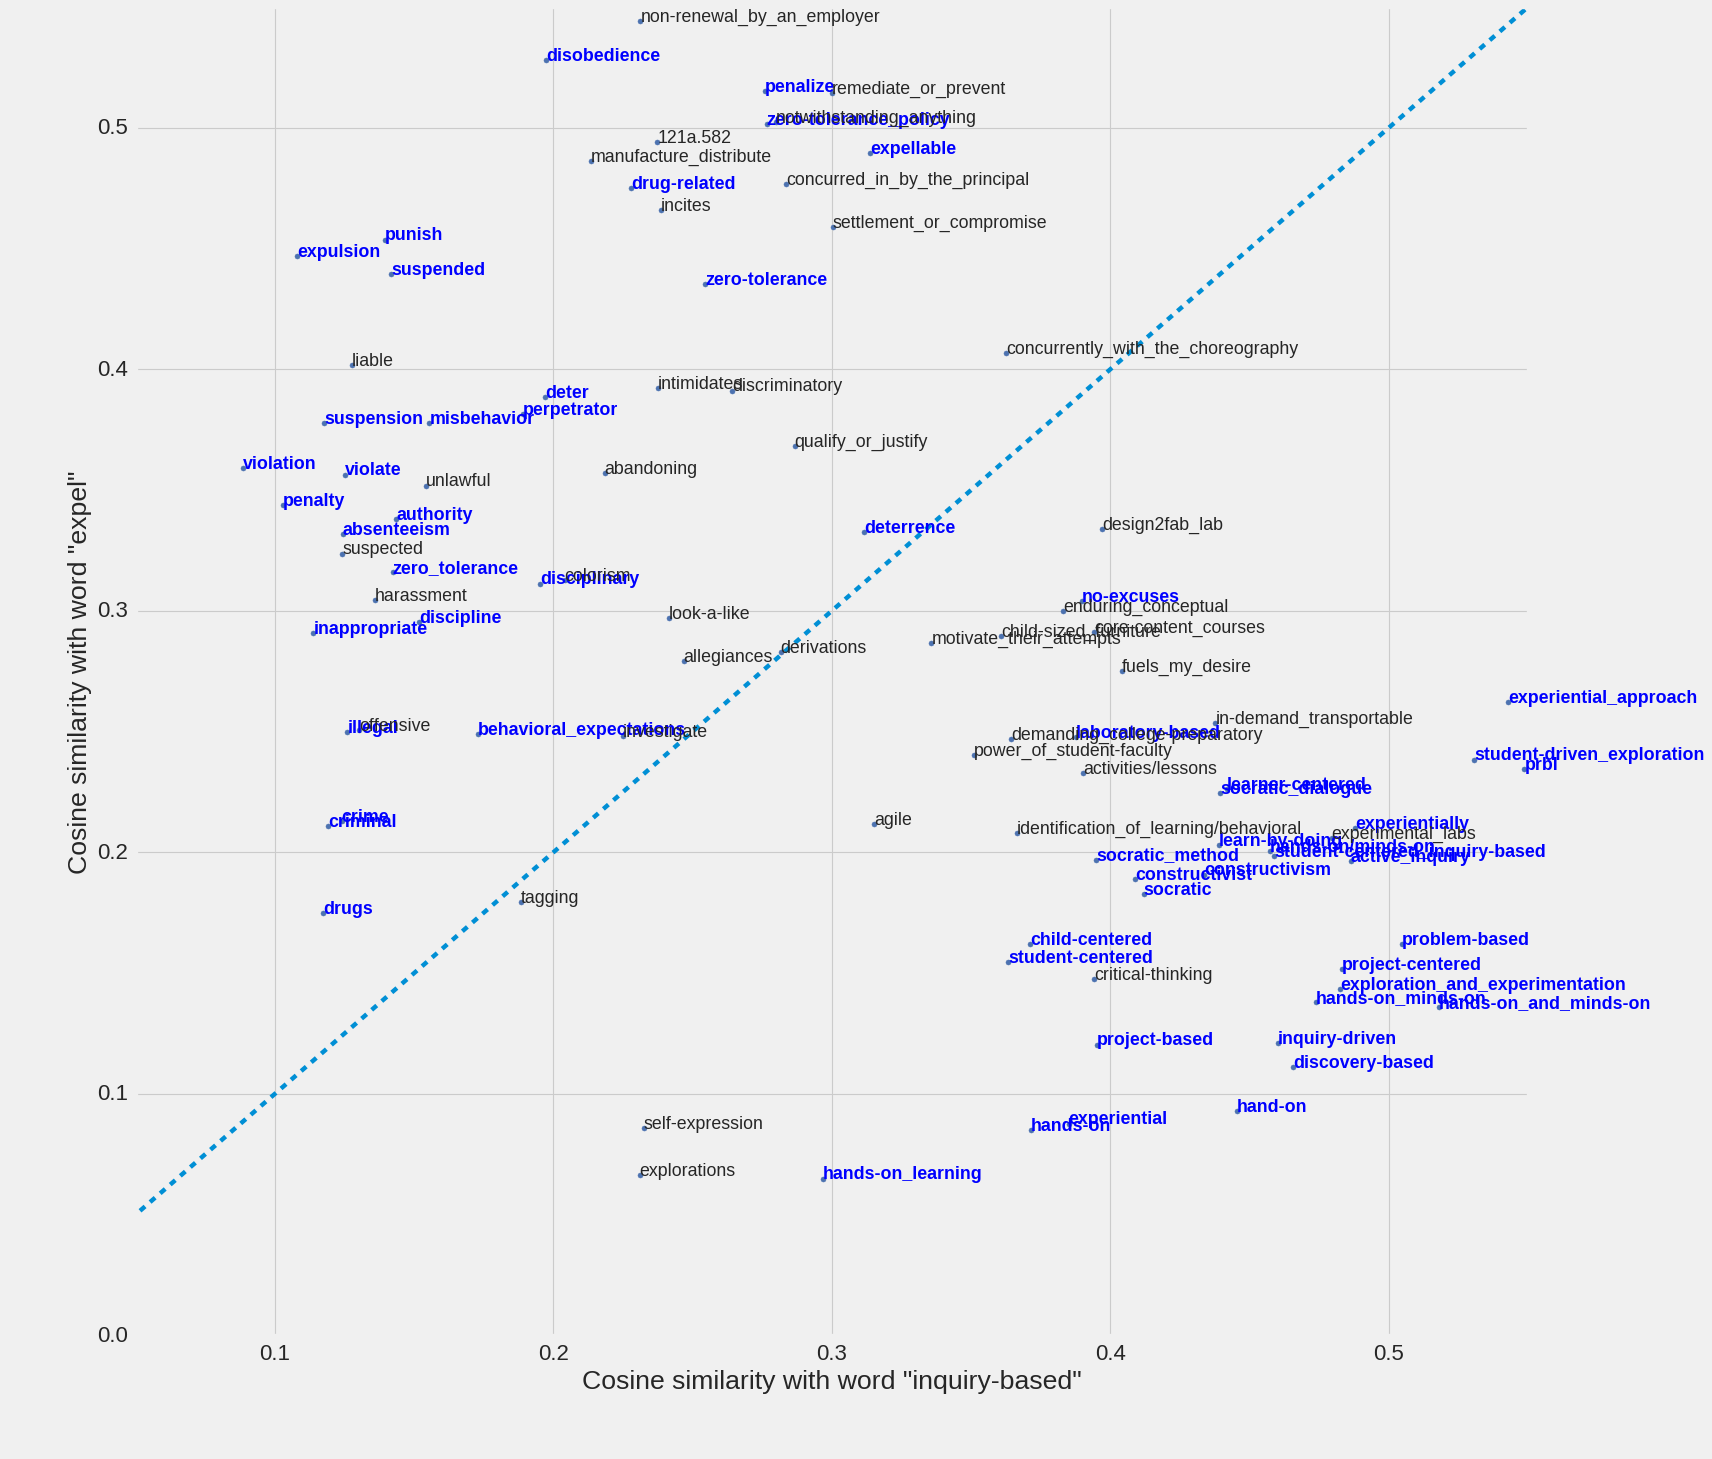

In [478]:
# here's a visual of the progressivism/essentialism binary: 
# top-left half is essentialism, bottom-right half is progressivism
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(x, y, alpha=1, color='b')
for i in range(len(id_words)):
    if id_words[i] in core_words:
        ax.annotate(id_words[i], (x[i], y[i]), fontweight='bold', color="blue").set_fontsize(16)
    else:
        ax.annotate(id_words[i], (x[i], y[i])).set_fontsize(16)
ax.set_xlim(.05, .55)
ax.set_xlabel('Cosine similarity with word "inquiry-based"')
ax.set_ylim(.0, .55)
ax.set_ylabel('Cosine similarity with word "expel"')
#ax.set_title()
ax.yaxis.label.set_fontsize(24)
ax.xaxis.label.set_fontsize(24)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
plt.plot([0, 1], [0, 1], linestyle='--');

### Binary of formal discipline (top-left) and inquiry-based learning (bottom-right) word vectors

In [479]:
fig.savefig("../data/WEM-binary_IBL-vs-FD_100318.png")